# Trend Analysis of Style Scores

Import models and data cleaning

In [1]:
import pandas as pd
import numpy as np

In [2]:
painting_feature = pd.read_csv("data/artwork_with_clip_features.csv")

In [3]:
def string_to_array(s):
    '''
    Change the string-like array into numpy.array
    Parameter:
        s: string to change with an array structure
    Output: array
    '''
    return np.fromstring(s.strip("[]"), sep=" ").tolist()

painting_feature['Feature_array'] = painting_feature['Feature'].apply(string_to_array)

In [4]:
painting_feature_nondup = painting_feature.drop_duplicates("image_n")

In [5]:
X_forpredict = np.vstack(painting_feature_nondup["Feature_array"])

In [6]:
import joblib

best_rfc = joblib.load('models/best_random_forest.pkl')
best_lr = joblib.load('models/best_lr_model.pkl')

/Users/pootaatoos/opt/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
style_score_rfc = best_rfc.predict_proba(X_forpredict)
style_score_lr = best_lr.predict_proba(X_forpredict)

Visualization

In [8]:
classes = best_rfc.classes_

In [9]:
rfc_df = pd.DataFrame(style_score_rfc, columns=classes)
lr_df = pd.DataFrame(style_score_lr, columns=classes)

In [10]:
painting_feature_nondup = painting_feature_nondup.reset_index()

In [11]:
rfc_combines = pd.concat([painting_feature_nondup, rfc_df], axis=1)
lr_combines = pd.concat([painting_feature_nondup, lr_df], axis=1)

In [12]:
def data_to_dict(data):

    df_dict = {}

    year_grouped = data.groupby("Year")

    for i in classes:
        year_group_mean = year_grouped[i].mean()
        year_group_max = year_grouped[i].max()
        year_group_min = year_grouped[i].min()
        year_group_std = year_grouped[i].std()
        year_group_n = year_grouped[i].count()
        se_values = year_group_std / np.sqrt(year_group_n)

        z_score = 1.96  # 95% confidence level
        upper_bound = year_group_mean + (z_score * se_values)
        lower_bound = year_group_mean - (z_score * se_values)
        
        df_dict[i] = pd.DataFrame({"Mean": year_group_mean,
                                "Max": year_group_max,
                                "Min": year_group_min,
                                "Std": year_group_std,
                                "Upper": upper_bound,
                                "Lower": lower_bound})
        
    return df_dict

In [13]:
rfc_df_dict = data_to_dict(rfc_combines)
lr_df_dict = data_to_dict(lr_combines)

In [30]:
classes_start_period = {'Abstract & Geometric Art': 1880, 
                'Academic & 19th Century Art': 1562,
                'Art Nouveau & Deco': 1890,
                'Conceptual & Minimalist Art': 1960,
                'Cubism & Futurism': 1907, 
                'Dada & Surrealism': 1916,
                'Expressionism & Fauvism': 1905, 
                'Impressionism & Post-Impressionism': 1862,
                'Kinetic & Optical Art': 1954, 
                'Modern & Postmodern Art': 1850,
                'Photorealism & Realism': 1840, 
                'Political & Social Art': 1920,
                'Pop Art & Op Art': 1950, 
                'Renaissance & Baroque': 1400, 
                'Symbolism & Fantasy': 1880,
                'Traditional & Regional Art': 250}

In [31]:
classes_sorted = sorted(classes_start_period.items(), key=lambda x: x[1])

In [16]:
import matplotlib.pyplot as plt


colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf", "#f4a261", "#e76f51", "#2a9d8f", "#264653", "#ffcc00", "#800000"
]

def plot_out_trend(df_dict, classes, name):
    for n in range(len(classes)):
        plt.figure(figsize=(10, 8))

        i = classes[n][0]
        color = colors[n]
        plt.plot(
            df_dict[i].index, 
            df_dict[i]["Mean"], 
            color=color,  
            label=i, 
            zorder=3,
            linewidth=1,
            alpha=1,
            marker='', 
            markersize=5
        )
        plt.axvline(x=classes[n][1], linestyle='--', color='gray', alpha=0.6)
        plt.ylim(0, 1)
        plt.xlim(1380, 2045)
        plt.xlabel("Year")
        plt.ylabel("Style Scores")
        plt.title("Trend of " + i)
        plt.grid(True)
        plt.savefig("img/Trend/" + name + "_Trend_" + i + ".pdf", bbox_inches="tight")
        plt.close()

    plt.figure(figsize=(10, 8))

    for n in range(len(classes)):
        i = classes[n][0]
        color = colors[n]
        plt.plot(
            df_dict[i].index, 
            df_dict[i]["Mean"], 
            color=color,  
            label=i, 
            zorder=3,
            linewidth=1,
            alpha=0.8,
            marker='', 
            markersize=5
        )

    plt.ylim(0, 1)
    plt.xlim(1380, 2045)
    plt.xlabel("Year")
    plt.ylabel("Style Scores")
    plt.title("Trend of Painting Styles")
    plt.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig("img/Trend/" + name + "_" + "Total_trend.pdf", bbox_inches="tight")
    plt.close()

In [32]:
plot_out_trend(rfc_df_dict, classes_sorted, "rfc")
plot_out_trend(lr_df_dict, classes_sorted, "lr")

In [28]:
import math

def plot_faceted_trends(df_dict, classes, name):
    num_classes = len(classes)
    rows = math.ceil(num_classes / 4) 
    cols = min(4, num_classes)

    fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
    axes = axes.flatten()

    for n in range(num_classes):
        i = classes[n][0]
        color = colors[n % len(colors)] 

        ax = axes[n]
        ax.plot(
            df_dict[i].index, 
            df_dict[i]["Mean"], 
            color=color,  
            label=i, 
            linewidth=1,
            alpha=1,
            marker='', 
            markersize=5
        )
        
        ax.axvline(x=classes[n][1], linestyle='--', color='black', alpha=0.9)
        ax.set_xlabel("Year")
        ax.set_ylim(0, 1)
        ax.set_xlim(1380, 2045)
        ax.set_title(i + "\n (Start Year: " + str(classes[n][1]) + ")", fontsize=16)
        ax.grid(True)

    for j in range(n + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    
    # Save faceted plot
    plt.savefig("img/Trend/" + name + "_" + "Total_trend_facted.pdf", bbox_inches="tight")
    plt.show()

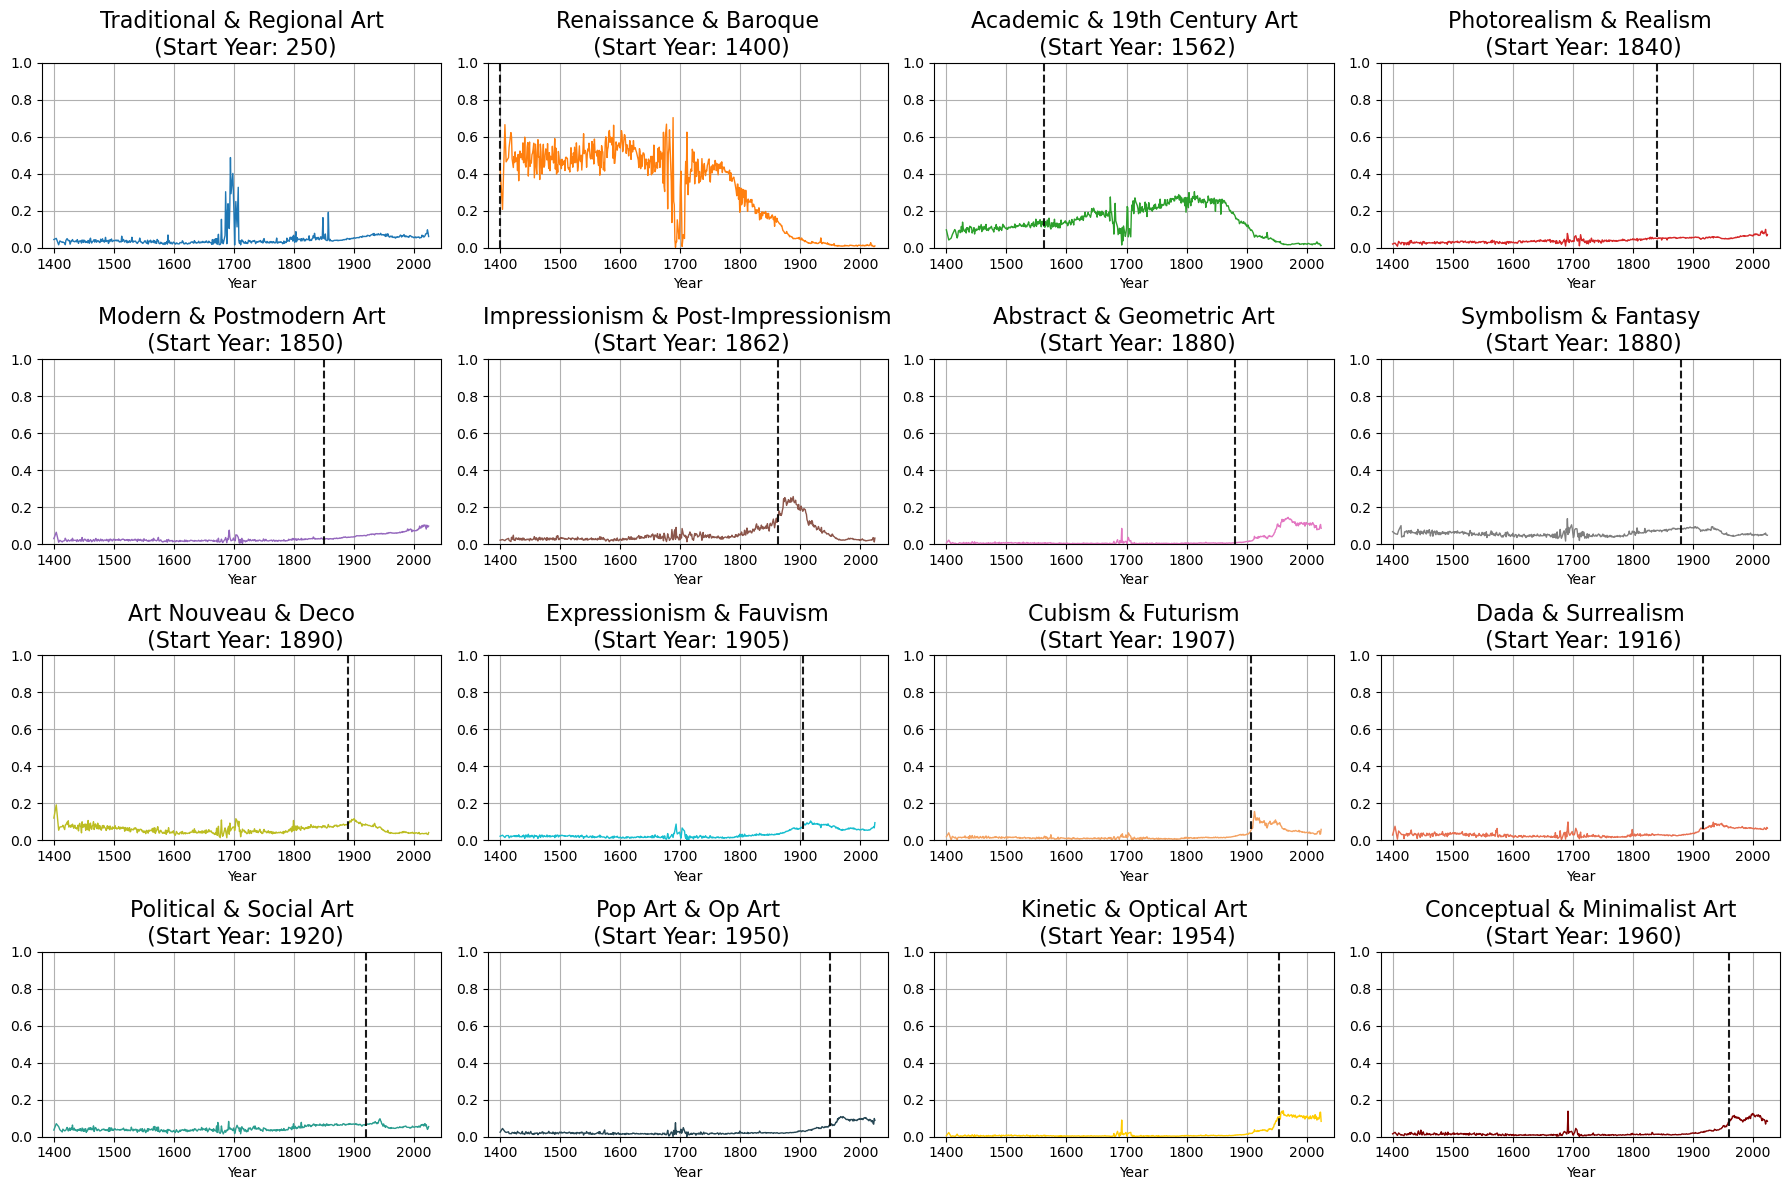

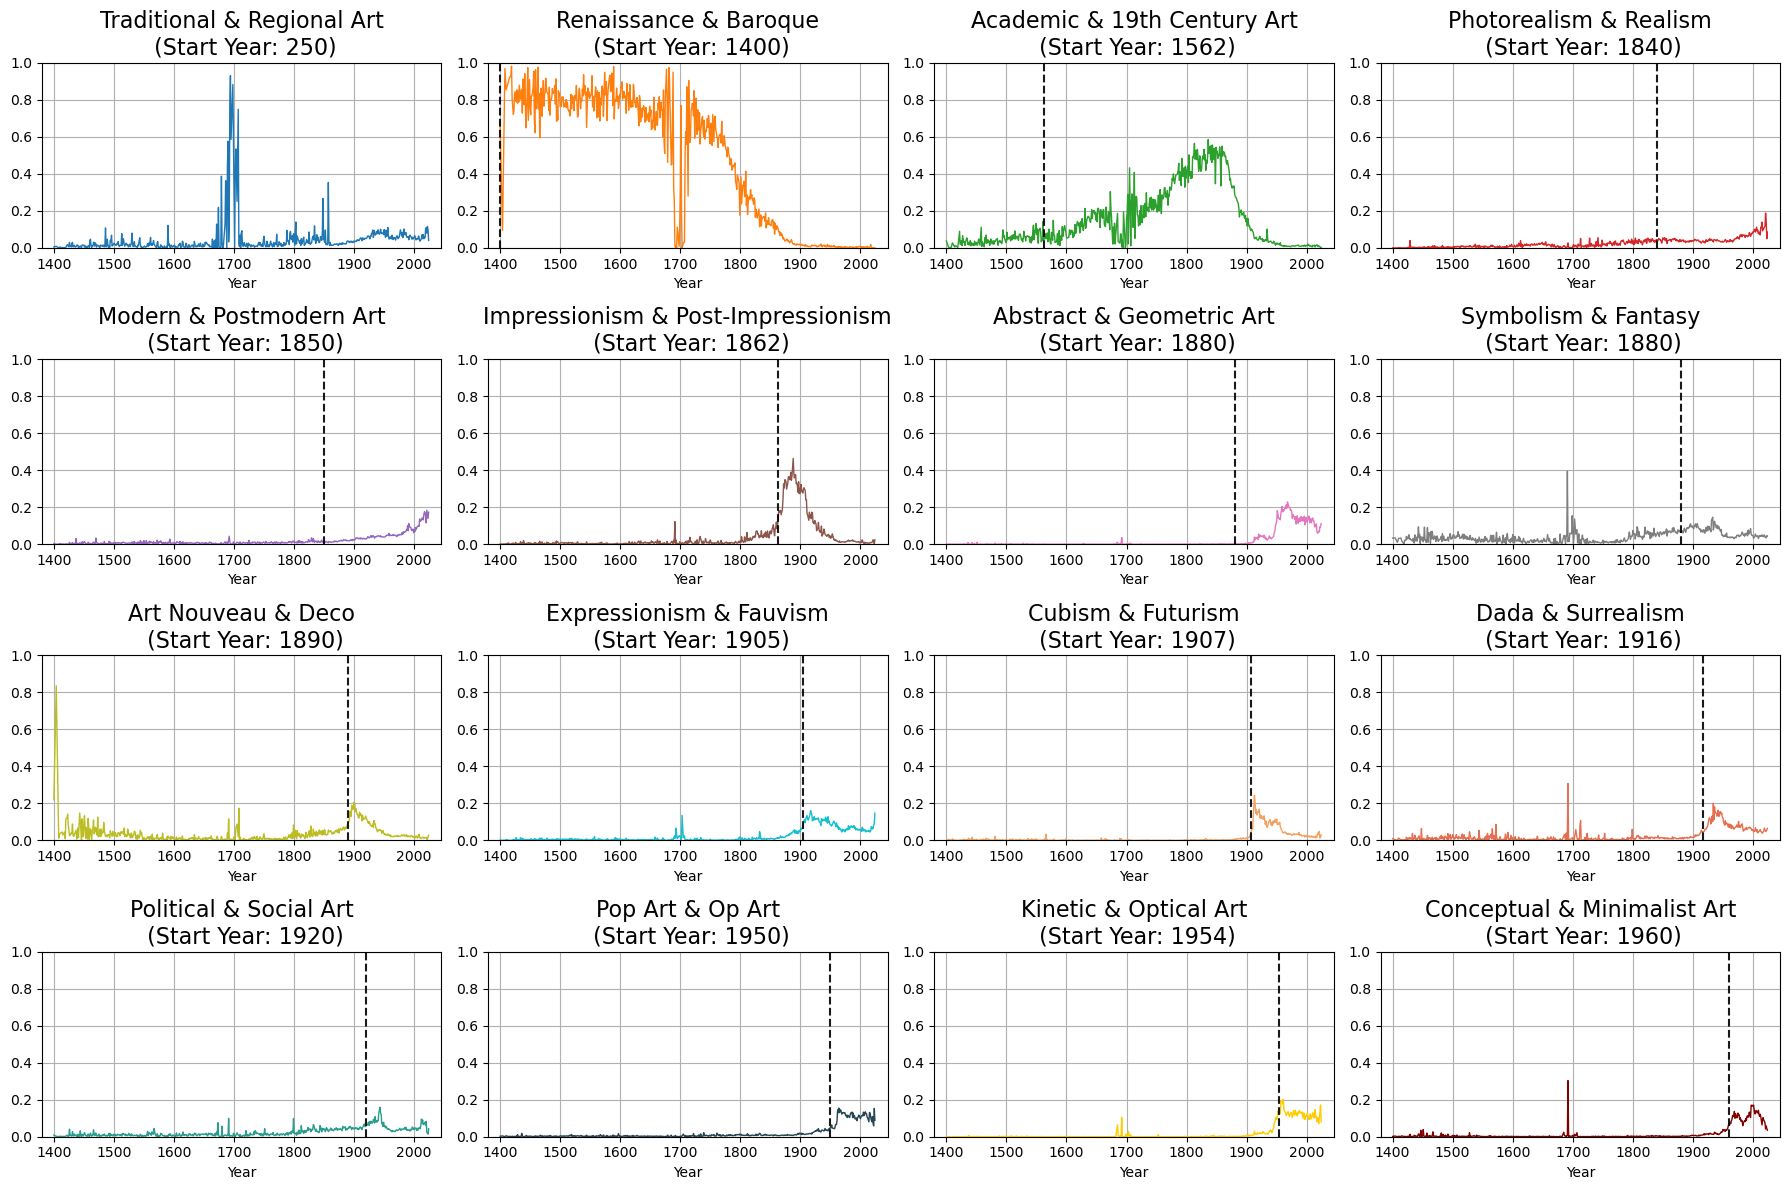

In [33]:
plot_faceted_trends(rfc_df_dict, classes_sorted, "rfc")
plot_faceted_trends(lr_df_dict, classes_sorted, "lr")